# **Ensemble Methods for Machine Learning - Final project**

Ames Housing Dataset (compiled by Dean De Cock):  https://www.kaggle.com/c/house-prices-advanced-regression-techniques/

### Overview:
- Goal: Predict the final price of each home.
- 79 features.
- 1460 examples in *train*, and 1459 examples in *test*.

In [1]:
#import os
#mingw_path = r'C:/Program Files/mingw-w64/x86_64-7.1.0-posix-seh-rt_v5-rev0/mingw64/bin'
#os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline

### Loading the data

In [2]:
df_train = pd.read_csv('train.csv', index_col='Id')
df_test = pd.read_csv('test.csv', index_col='Id')

### Results of data exploration

- 44 categorical variables ("MSSubClass" included --> see preprocessing)
- 35 numeric variables ("SalePrice" and "MSSubClass" not included)
- Most of the values in categorical variables which are recognized as NaN by pandas are actually 'NA' labels. 
    - E.g., in 'Alley', NA stands for 'No alley access'.
- "SalePrice" distribution is not normal

In [3]:
#categorical features
print('Categorical: ', df_train.select_dtypes(include=['object']).columns)

#numerical features (see comment about 'MSSubCLass' here above)
print('Numerical: ', df_train.select_dtypes(exclude=['object']).columns)

Categorical:  Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
Numerical:  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
   

In [4]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

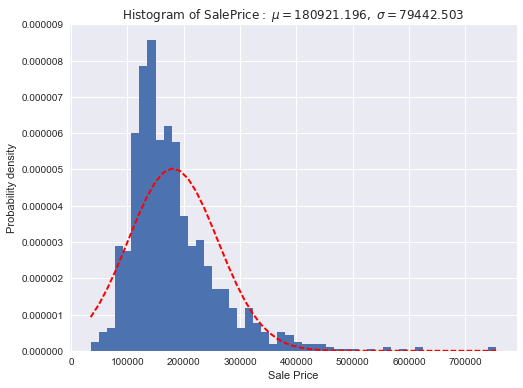

In [5]:
# mean distribution
mu = df_train['SalePrice'].mean()
# std distribution
sigma = df_train['SalePrice'].std()
num_bins = 50

plt.figure(figsize=(8, 6))
n, bins, patches = plt.hist(df_train['SalePrice'], num_bins, normed=1)

y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--', linewidth=2)
plt.xlabel('Sale Price')
plt.ylabel('Probability density')

plt.title(r'$\mathrm{Histogram\ of\ SalePrice:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.grid(True)
#fig.tight_layout()
plt.show()

We normalize it using log-transformation.

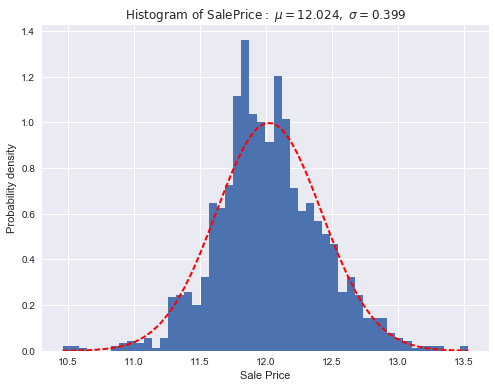

In [6]:
sale_price_norm = np.log1p(df_train['SalePrice'])

# mean distribution
mu = sale_price_norm.mean()
# std distribution
sigma = sale_price_norm.std()
num_bins = 50

plt.figure(figsize=(8, 6))
n, bins, patches = plt.hist(sale_price_norm, num_bins, normed=1)

y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--', linewidth=2)
plt.xlabel('Sale Price')
plt.ylabel('Probability density')

plt.title(r'$\mathrm{Histogram\ of\ SalePrice:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.grid(True)
#fig.tight_layout()
plt.show()

We look at the correlation between features. We display only the lower triangle, because the entries on the diagonal are all 1s and the matrix is symmetric.

We see that:
- 'OverallQual' (0.79) and 'GrLivArea' (0.71) highly correlate with 'SalePrice'. 
- 'GarageArea' and 'GarageCars' (0.88) highly correlate.
- 'TotalRmsAbvGrd' and 'GrLivArea' (0.83) highly correlate.
- '1stFlrSF' and 'TotalBsmtSF' (0.82) highly correlate.

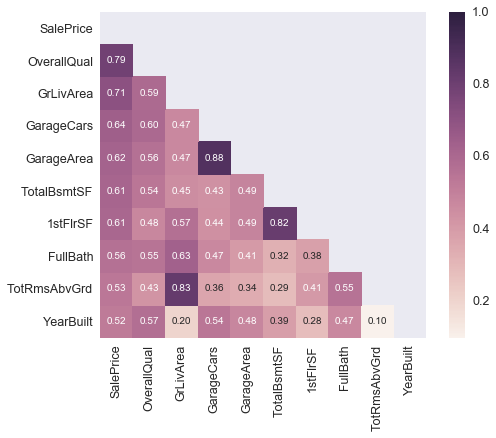

In [7]:
#correlation matrix
corrmat = df_train.corr()
plt.figure(figsize=(8, 6))

#number of variables for heatmap
k = 10 
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)

#generate mask for upper triangle
mask = np.zeros_like(cm, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.set(font_scale=1.25)
sns.heatmap(cm, mask=mask, cbar=True, annot=True, square=True,\
                 fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values,\
                 xticklabels=cols.values)
plt.show()

Let's plot 'GrLivArea', 'GarageArea', '1stFlrSF', 'TotalBsmtSF' and eyeball their distributions.

- 'GrLivArea'
- 'GarageArea'
- '1stFlrSF'
- 'TotalBsmtSF'

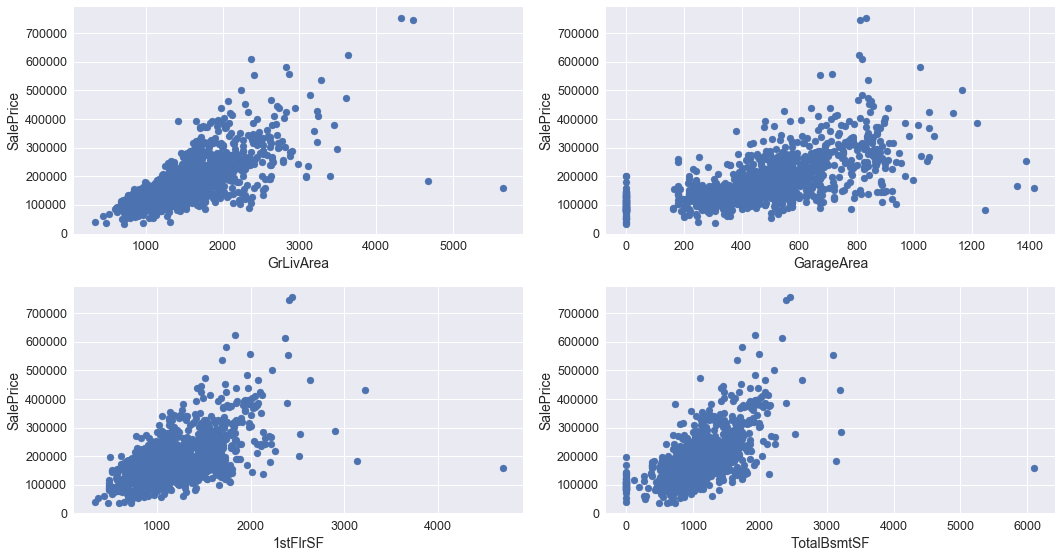

In [8]:
to_be_plotted = ['GrLivArea', 'GarageArea', '1stFlrSF', 'TotalBsmtSF']

plt.figure(figsize=(15, 8))

for i, entry in enumerate(to_be_plotted):
    plt.subplot(2, 2, i+1)
    plt.scatter(df_train[entry], df_train['SalePrice'])
    plt.xlabel(entry)
    plt.ylabel('SalePrice')

plt.tight_layout()
plt.show()

### Missing data

#### Numerical
LotFrontage
- TRAIN + TEST: not specified, perhaps no frontage lot. We fill up the NaNs with 0s (i.e., zeros).


#### Categorical
PoolQC
- TRAIN: It seems that 99.5% of the entries for this features are NaN, but this is incorrect. pandas reads the label 'NA' (i.e., No Pool) as NaN. This means that 1453 houses in the training set have no pool (because all the 1453 houses have PoolArea=0).
- TEST: The same applies here, but with three houses, which actually have NaNs for this feature.
- We will use 'None' to fill up those entries where PoolArea=0, whereas we will use 'TA' (mode) to fill up the gaps of the three exceptions in the test set.


MiscFeature
- TRAIN + TEST: all the NaNs mean in reality "None", i.e., no miscellaneous features.


The same applies to Alley, Fence, and FireplaceQu.

In [9]:
# TRAIN
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(6)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397


In [10]:
# TEST
total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(6)

,Total,Percent
PoolQC,1456,0.997944
MiscFeature,1408,0.965045
Alley,1352,0.926662
Fence,1169,0.801234
FireplaceQu,730,0.500343
LotFrontage,227,0.155586


### Outliers

Standardize TRAIN (i.e., center feature columns at mean 0 with standard deviation 1). Outliers are where: [s > s.std() * 3] is TRUE.

We check 'GrLivArea', 'GarageArea', '1stFlrSF', and 'TotalBsmtSF'.

Examples (Id) 524 and 1299 appear multiple times as outliers. We will drop them from the training data during preprocessing. Examples 1183 and 692 appear multiple times as well, but we leave them in the training set because our model performs worse if they are removed.


In [11]:
scaled_features = StandardScaler().fit_transform(df_train[['GrLivArea', 'GarageArea', \
                                                           '1stFlrSF', 'TotalBsmtSF']])
df_standard = pd.DataFrame(scaled_features, index=df_train.index, columns=['GrLivArea', \
                                                                           'GarageArea', '1stFlrSF', 'TotalBsmtSF'])
to_be_checked = ['GrLivArea', 'GarageArea', '1stFlrSF', 'TotalBsmtSF']

for entry in to_be_checked:
    print(entry.upper())
    s = df_standard[entry]
    print(s[s > s.std() * 3])

GRLIVAREA
Id
119     3.248687
186     3.983504
198     3.039283
305     3.764582
497     3.260109
524     6.016627
609     3.195384
636     3.578022
692     5.331304
770     3.357196
799     3.092585
1170    4.019674
1183    5.635892
1269    3.677013
1299    7.855574
1354    3.279145
Name: GrLivArea, dtype: float64
GARAGEAREA
Id
179     3.242477
582     4.290521
665     3.092757
826     3.495131
1062    3.626136
1191    4.131443
1299    4.421526
Name: GarageArea, dtype: float64
1STFLRSF
Id
225     3.181152
441     3.207029
497     5.344404
524     5.111518
530     3.499430
692     3.315709
899     3.108699
1025    4.490489
1045    3.522718
1183    3.230317
1299    9.132681
1374    3.804769
Name: 1stFlrSF, dtype: float64
TOTALBSMTSF
Id
225      3.043108
333      4.899204
441      4.643820
497      4.885522
524      4.744149
692      3.161680
1045     3.344097
1183     3.052229
1299    11.520949
1374     3.592640
Name: TotalBsmtSF, dtype: float64


We concatenate training and test sets in order to have a better overview of the distribution. We plot an histogram for each continuous variable and check for skewness (we remove 'SalePrice' because it is only present in the training set) - We do not do this for ordinal and categorical variables, because they are not from a normal distribution (see https://stats.stackexchange.com/questions/129415/how-can-i-determine-if-categorical-data-is-normally-distributed). Before plotting, we need to replace the NaNs with 0s.

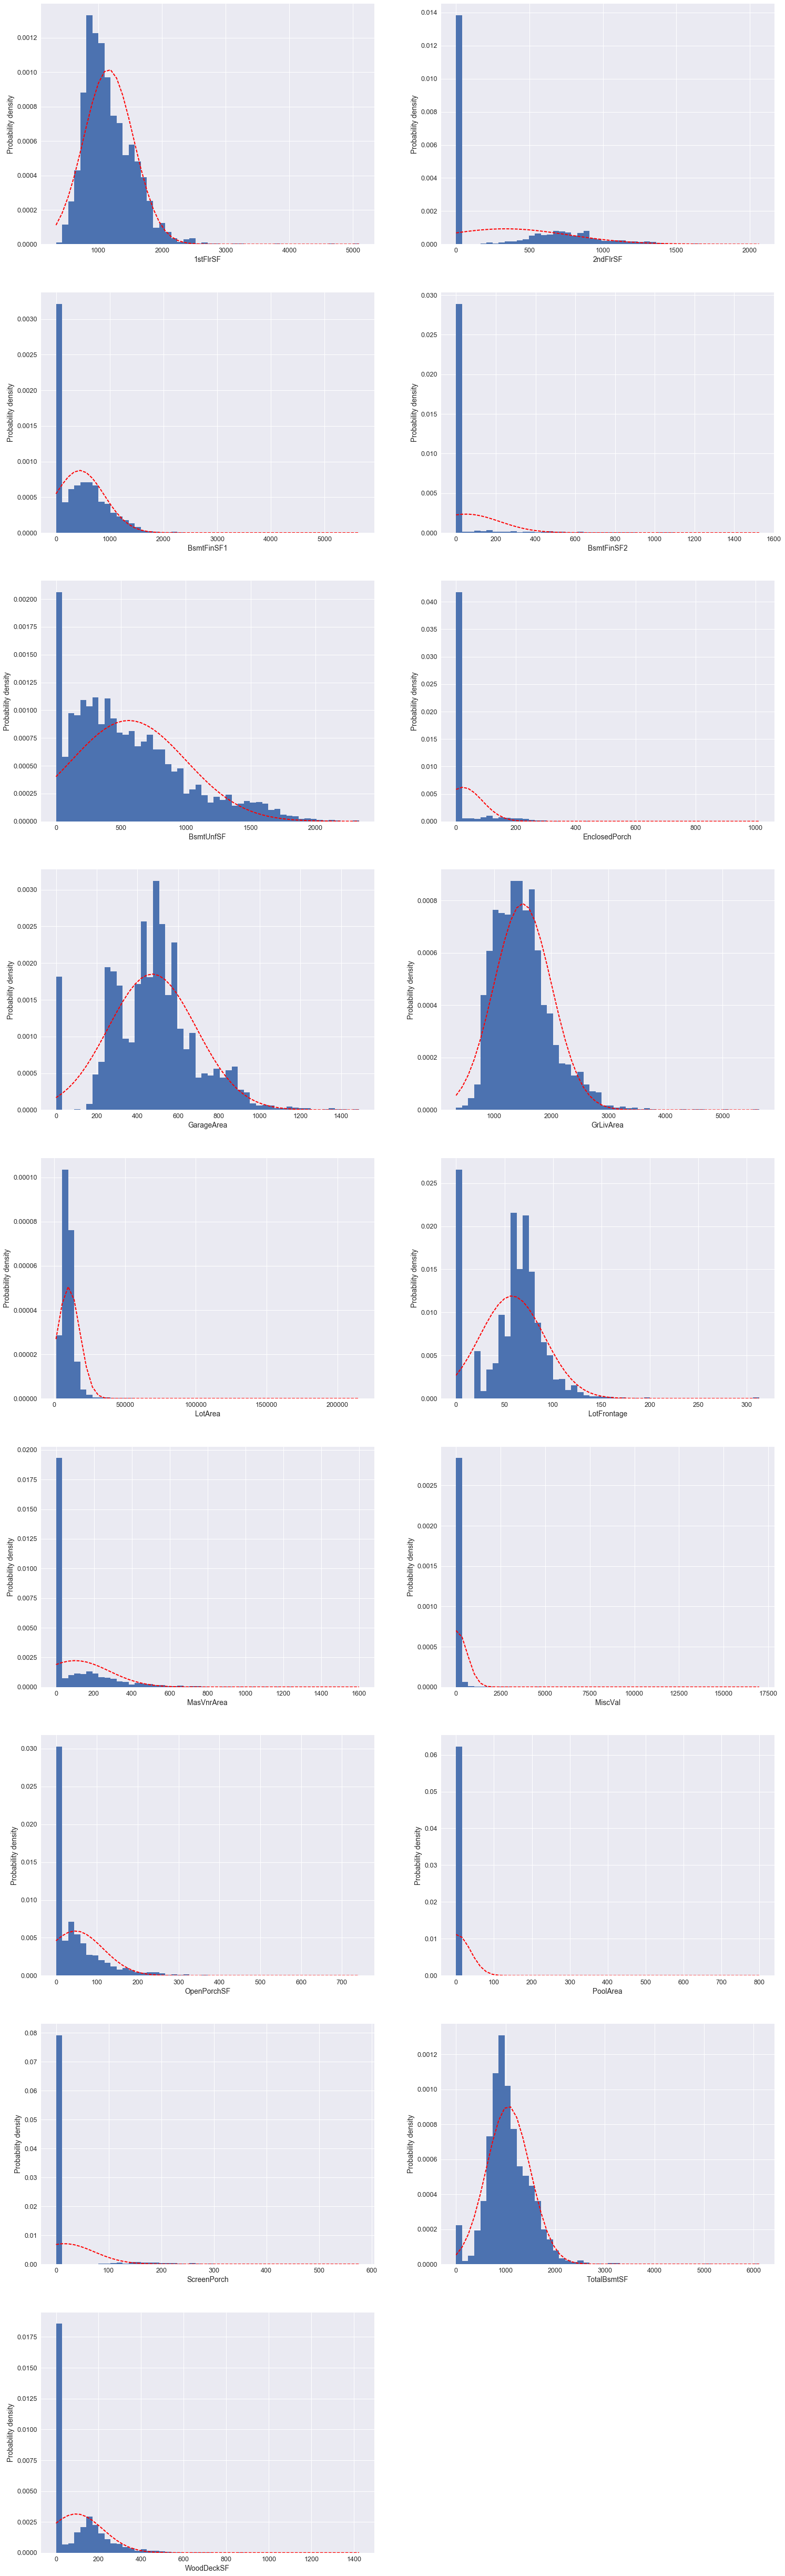

In [12]:
dataset = pd.concat([df_train, df_test])

to_be_plotted = ['1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'EnclosedPorch',\
                'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'MiscVal',\
                'OpenPorchSF', 'PoolArea', 'ScreenPorch', 'TotalBsmtSF', 'WoodDeckSF']



def plot_distribution(to_be_plotted):
    plt.figure(figsize=(25, 180))
    for i, entry in enumerate(to_be_plotted):
        plt.subplot(18, 2, i+1)
        # fill NaNs with 0
        dataset[entry].fillna(0, inplace=True)
        # mean distribution
        mu = dataset[entry].mean()
        # std distribution
        sigma = dataset[entry].std()
        num_bins = 50
        n, bins, patches = plt.hist(dataset[entry], num_bins, normed=1)
        y = mlab.normpdf(bins, mu, sigma)
        plt.plot(bins, y, 'r--', linewidth=2)
        plt.xlabel(entry)
        plt.ylabel('Probability density')
        plt.grid(True)
    plt.show()
    

plot_distribution(to_be_plotted)

Let's check for the skew of these variables. What skew tells us is how symmetric a distribution is. In particular, a symmetrical dataset will have a skewness equal to 0. Skewness essentially measures the relative size of the two tails.

We use Pandas's skew (rather than Scipy's) that corrects for bias by default (https://stackoverflow.com/questions/33109107/what-is-the-difference-between-skew-and-kurtosis-functions-in-pandas-vs-scipy). 

The results indicate that most of the distributions are not symmetric. Let's log transform all those feature with skew > 3

In [13]:
for entry in to_be_plotted:
    print(entry, ':', dataset[entry].skew())

1stFlrSF : 1.47036010554
2ndFlrSF : 0.862117832566
BsmtFinSF1 : 1.42596305493
BsmtFinSF2 : 4.14827526728
BsmtUnfSF : 0.919811968624
EnclosedPorch : 4.0059500705
GarageArea : 0.23937994894
GrLivArea : 1.27001040752
LotArea : 12.829024853
LotFrontage : 0.0220241790558
MasVnrArea : 2.61493607062
MiscVal : 21.9584803244
OpenPorchSF : 2.53641731605
PoolArea : 16.9070172436
ScreenPorch : 3.94872314129
TotalBsmtSF : 1.15748902582
WoodDeckSF : 1.84338021266


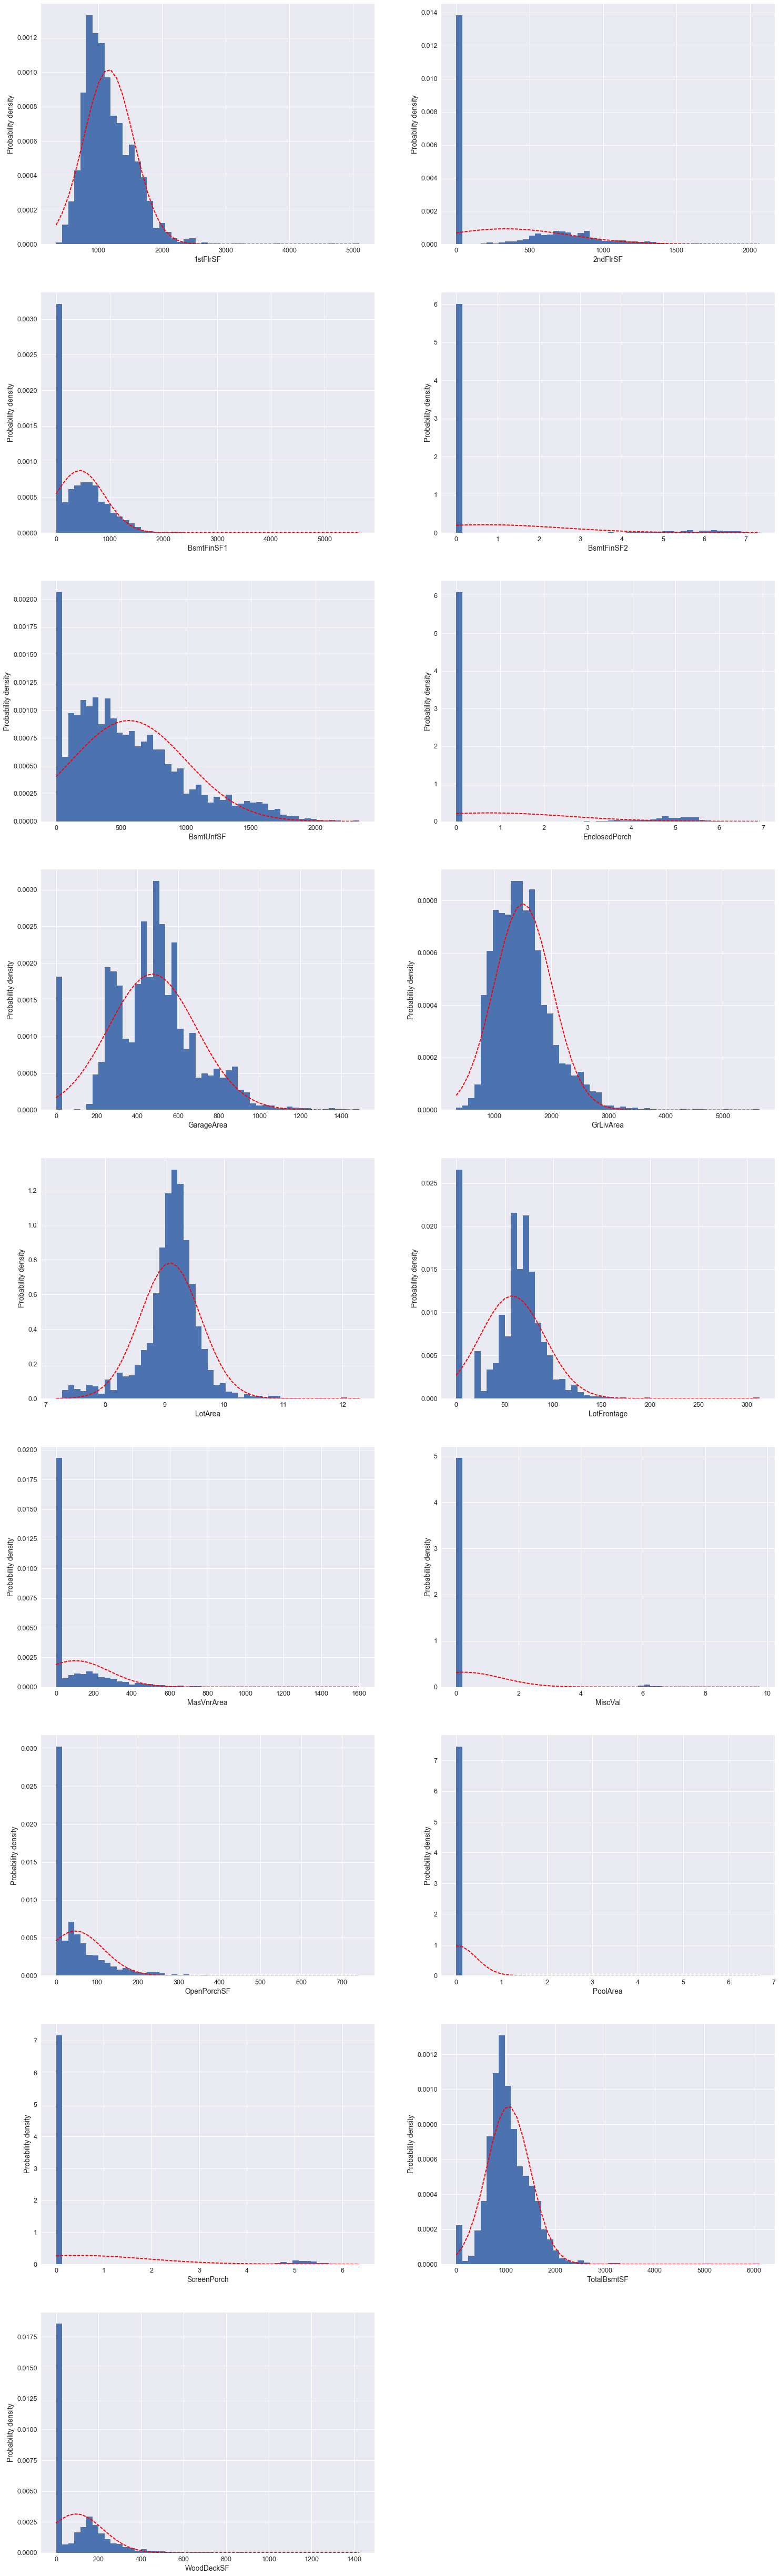

In [14]:
for entry in to_be_plotted:
    if dataset[entry].skew() > 3:
        dataset[entry] = np.log1p(dataset[entry])
    
plot_distribution(to_be_plotted)

### Preprocessing

We create a function called "preprocessing" which implements the ideas discussed here above. The function also includes feature engineering, feature scaling and the creation of dummy variables from categorical ones.


#### Feature engineering
"Feature engineering is the process of transforming raw data into features that better represent the underlying problem to the predictive models, resulting in improved model accuracy on unseen data." (http://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/)


#### Feature scaling - Standardization
Feature scaling is a fundamental step in preprocessing. It means that we bring all the features on the same scale.
When dealing with decision trees and random forests we do not have to worry about feature scaling, as trees are robust to outliers.
Standardization is a common approach to feature scaling and is practical for many machine learning algorithms, because many linear models initialize the weights to 0 or small random values close to 0. "Using standardization, we center the feature columns at mean 0 with standard deviation 1, which makes it easier to learn the weights." (from: Raschka 2016, 111).


#### One-hot vectors (dummy variables)
"One-hot encoding transforms categorical features to a format that works better with classification and regression algorithms." (https://www.quora.com/What-is-one-hot-encoding-and-when-is-it-used-in-data-science)

In [15]:
def preprocessing(df_train, df_test):
    '''
    Parameters
    ----------
    df_train : pandas Dataframe
    df_test : pandas Dataframe
    
    Return
    ----------
    df_train : pandas Dataframe
    df_test : pandas Dataframe
    y_train : pandas Series
    '''
    # remove outliers in GrLivArea
    df_train.drop(df_train[df_train['GrLivArea'] > 4500].index, inplace=True)   

    # Normalize SalePrice using log_transform
    y_train = np.log1p(df_train['SalePrice'])
    # Remove SalePrice from training and merge training and test data
    df_train.pop('SalePrice')
    dataset = pd.concat([df_train, df_test])

    # Numerical variable with "categorical meaning"
    # Cast it to str so that we get dummies later on
    dataset['MSSubClass'] = dataset['MSSubClass'].astype(str)

    
    ### filling NaNs ###
    # no alley
    dataset["Alley"].fillna("None", inplace=True)

    # no basement
    dataset["BsmtCond"].fillna("None", inplace=True)
    dataset["BsmtExposure"].fillna("None", inplace=True)
    dataset["BsmtFinSF1"].fillna(0, inplace=True)               
    dataset["BsmtFinSF2"].fillna(0, inplace=True)               
    dataset["BsmtUnfSF"].fillna(0, inplace=True)                
    dataset["TotalBsmtSF"].fillna(0, inplace=True)
    dataset["BsmtFinType1"].fillna("None", inplace=True)
    dataset["BsmtFinType2"].fillna("None", inplace=True)
    dataset["BsmtFullBath"].fillna(0, inplace=True)
    dataset["BsmtHalfBath"].fillna(0, inplace=True)
    dataset["BsmtQual"].fillna("None", inplace=True)

    # most common electrical system
    dataset["Electrical"].fillna("SBrkr", inplace=True)

    # one missing in test; set to other
    dataset["Exterior1st"].fillna("Other", inplace=True)
    dataset["Exterior2nd"].fillna("Other", inplace=True)

    # no fence
    dataset["Fence"].fillna("None", inplace=True)

    # no fireplace
    dataset["FireplaceQu"].fillna("None", inplace=True)

    # fill with typical functionality
    dataset["Functional"].fillna("Typ", inplace=True)

    # no garage
    dataset["GarageArea"].fillna(0, inplace=True)
    dataset["GarageCars"].fillna(0, inplace=True)
    dataset["GarageCond"].fillna("None", inplace=True)
    dataset["GarageFinish"].fillna("None", inplace=True)
    dataset["GarageQual"].fillna("None", inplace=True)
    dataset["GarageType"].fillna("None", inplace=True)
    dataset["GarageYrBlt"].fillna("None", inplace=True)

    # "typical" kitchen
    dataset["KitchenQual"].fillna("TA", inplace=True)

    # lot frontage (no explanation for NA values, perhaps no frontage)
    dataset["LotFrontage"].fillna(0, inplace=True)

    # Masonry veneer (no explanation for NA values, perhaps no masonry veneer)
    dataset["MasVnrArea"].fillna(0, inplace=True)
    dataset["MasVnrType"].fillna("None", inplace=True)

    # most common value
    dataset["MSZoning"].fillna("RL", inplace=True)

    # no misc features
    dataset["MiscFeature"].fillna("None", inplace=True)

    # description says NA = no pool, but there are entries with PoolArea >0 and PoolQC = NA. Fill the ones with values with average condition
    dataset.loc[(dataset['PoolQC'].isnull()) & (dataset['PoolArea']==0), 'PoolQC' ] = 'None'
    dataset.loc[(dataset['PoolQC'].isnull()) & (dataset['PoolArea']>0), 'PoolQC' ] = 'TA'

    # classify missing SaleType as other
    dataset["SaleType"].fillna("Other", inplace=True)

    # most common
    dataset["Utilities"].fillna("AllPub", inplace=True)

    
    ### feature engineering ###
    # create new binary variables: assign 1 to mode
    dataset["IsRegularLotShape"] = (dataset["LotShape"] == "Reg") * 1
    dataset["IsLandLevel"] = (dataset["LandContour"] == "Lvl") * 1
    dataset["IsLandSlopeGentle"] = (dataset["LandSlope"] == "Gtl") * 1
    dataset["IsElectricalSBrkr"] = (dataset["Electrical"] == "SBrkr") * 1
    dataset["IsGarageDetached"] = (dataset["GarageType"] == "Detchd") * 1
    dataset["IsPavedDrive"] = (dataset["PavedDrive"] == "Y") * 1
    dataset["HasShed"] = (dataset["MiscFeature"] == "Shed") * 1
    # was the house remodeled? if yes, assign 1
    dataset["Remodeled"] = (dataset["YearRemodAdd"] != dataset["YearBuilt"]) * 1
    # assign 1 to houses which were sold the same year they were remodeled
    dataset["RecentRemodel"] = (dataset["YearRemodAdd"] == dataset["YrSold"]) * 1
    # assign 1 to houses which were sold the same year they were built
    dataset["VeryNewHouse"] = (dataset["YearBuilt"] == dataset["YrSold"]) * 1

    
    ### normalization ###
    # normalize distribution for continuous variables with skew > 3
    continuous_vars = ['1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'EnclosedPorch',\
                'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'MiscVal',\
                'OpenPorchSF', 'PoolArea', 'ScreenPorch', 'TotalBsmtSF', 'WoodDeckSF']
    skew_threshold = 3
    for entry in continuous_vars:
        if dataset[entry].skew() > skew_threshold:
            dataset[entry] = np.log1p(dataset[entry])
    
    
    ### standardization ###
    # standardization for continuous variables
    sub_df = dataset[continuous_vars]
    array_standard = StandardScaler().fit_transform(sub_df)
    df_standard = pd.DataFrame(array_standard, dataset.index, continuous_vars)
    dataset.drop(dataset[continuous_vars], axis=1, inplace=True)
    dataset = pd.concat([dataset, df_standard], axis=1)
    
    
    ### dummies ###
    # split back to training and test set
    df_train_len = len(df_train)
    df_dummies =  pd.get_dummies(dataset)
    df_train = df_dummies[:df_train_len]
    df_test = df_dummies[df_train_len:]

    return df_train, df_test, y_train


### Model evaluation and Hyperparameter tuning

We preprocess the training and test sets. Then we split the training set into X_train (80% of the original size of df_train) and X_validation (20% of the original size of df_train). 

The validation set is important for cross-validation. Cross-validation helps us find an acceptable bias-variance tradeoff. What is the bias-variance tradeoff?
A model can either suffer from underfitting (high bias; the model is too simple for the underlying training data) or overfitting (high variance; the model is too complex for the underlying training data). Cross-validation helps us find a good compromise between these two. 

REVIEW - From: Raschka 2016, 66
- **Variance**: measures the consistency of the model prediction for a particular sample instance if we would retrain the model multiple times (e.g., on different subsets of the training set). The model is sensitive to the randomness in the training data.
- **Bias**: measures how far off the predictions are from the correct values in general if we rebuild the model multiple times on different training datasets. Bias is the measure of systematic error that is not due to randomness.

For a graphical definition of bias and variance see 1.2 in http://scott.fortmann-roe.com/docs/BiasVariance.html

In [16]:
df_train, df_test, y_train_before_split = preprocessing(df_train, df_test)

# 80/20 split for df_train
validation_size = 0.2
seed = 3
X_train, X_validation, y_train, y_validation = train_test_split(df_train, y_train_before_split, \
            test_size=validation_size, random_state=seed)
X_test = df_test

#### Models
We are going to fit different models to our training data. Concretely, we will fit two linear models (LassoCV and RidgeCV) and two ensemble models (RandomForestRegressor and GradientBoostingRegressor).

**Ridge regression** in short: an L2 penalized model where we add the squared sum of the weights (scaled by lambda) to the least-square cost function.

$$ J(w)_{Ridge} = \sum\limits_{i=1}^n (y^{(i)} - \hat{y}^{(i)})^2 + \lambda \sum\limits_{j=1}^m w_j^2 $$

**Lasso regression** in short: an L1 penalized model where we add the sum of the absolute values of the weights (scaled by lambda) to the least-square cost function.

$$ J(w)_{Lasso} = \sum\limits_{i=1}^n (y^{(i)} - \hat{y}^{(i)})^2 + \lambda \sum\limits_{j=1}^m | w_j | $$

You find a good tutorial about Lasso regression and Ridge regression at https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/

**RandomForestRegressor** in short: an ensemble of different regression trees, where each leaf contains a distribution for the continuous output variable/s. More about it: https://www.quora.com/How-does-random-forest-work-for-regression-1

**GradientBoostingRegressor** (Gradient Boosting = Gradient descent + Boosting) in short: identifies the ‘shortcomings’ of weaker learners by gradients in the loss function.

More about ensemble methods: http://scikit-learn.org/stable/modules/ensemble.html


#### K-fold cross-validation: cross_val_score uses K-Fold implictly in this case (see documentation)
Theory: In K-fold cross-validation, the training set is split into *k* folds without replacement, i.e., each example will be part of exactly one fold. *k-1* folds are used for training and the remaining fold is used for testing. This procedure is repeated for *k* iterations. Thus, we obtain *k* models and performance estimates.

Estimated average performance *E* of a model: $$ E = \frac{1}{K} \sum\limits_{i=1}^k E_k $$


#### Scoring
The predifined scorer objects in sklearn for regression are 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_median_absolute_error', and 'r2'. Here we use 'r2' (http://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score)

In [17]:
# list of tuples: the first element is a string, the second is an object
estimators = [('LassoCV', LassoCV()), ('RidgeCV', RidgeCV()),\
              ('RandomForest', RandomForestRegressor()), ('GradientBoosting', GradientBoostingRegressor()),\
              ('ElasticNetCV', ElasticNetCV())]

for estimator in estimators:
    scores = cross_val_score(estimator=estimator[1],
                            X=X_train,
                            y=y_train,
                            scoring='r2',
                            cv=3,
                            n_jobs=-1)
    #print('CV accuracy scores: %s' % scores)
    print(estimator[0], 'CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

LassoCV CV accuracy: 0.902 +/- 0.004
RidgeCV CV accuracy: 0.918 +/- 0.004
RandomForest CV accuracy: 0.865 +/- 0.007
GradientBoosting CV accuracy: 0.903 +/- 0.008
ElasticNetCV CV accuracy: 0.902 +/- 0.004


### Tune hyperparameters using GridSearchCV
The models that we have chosen perform ok, but we can improve their performance by tuning the hyperparameters, i.e., those parameters that are *not* learned from the training data.

In order to do so, we will use an operation technique called **grid search** that will help us finding the *optimal* combination of hyperparameter values. Grid search is a brute-force exhaustive search paradigm.

After hyperparameter tuning, we notice that the linear models outperform the ensemble methods.

In [18]:
#LassoCV
gs = GridSearchCV(
                estimator=LassoCV(),
                param_grid={'eps':[10**-7, 10**-5, 10**-3],
                            'n_alphas':[25, 50, 75]},
                scoring='r2',
                cv=3,
                n_jobs=-1)

gs = gs.fit(X_train, y_train)
print('LassoCV:')
print('Training accuracy: %.3f' % gs.best_score_)
print(gs.best_params_)
est = gs.best_estimator_
est.fit(X_train, y_train)
print('Best alpha: ', est.alpha_)
print('Validation accuracy: %.3f' % est.score(X_validation, y_validation))

LassoCV:
Training accuracy: 0.921
{'n_alphas': 75, 'eps': 1e-07}
Best alpha:  0.000770911831347
Validation accuracy: 0.912


In [29]:
#RidgeCV
gs = GridSearchCV(
                estimator=RidgeCV(),
                param_grid={'fit_intercept':[True, False]},
                scoring='r2',
                cv=3,
                n_jobs=-1)

gs = gs.fit(X_train, y_train)
print('RidgeCV:')
print('Training accuracy: %.3f' % gs.best_score_)
print(gs.best_params_)
est = gs.best_estimator_
est.fit(X_train, y_train)
print('Best alpha: ', est.alpha_)
print('Validation accuracy: %.3f' % est.score(X_validation, y_validation))

RidgeCV:
Training accuracy: 0.918
{'fit_intercept': True}
Best alpha:  10.0
Validation accuracy: 0.908


In [20]:
#RandomForest
gs = GridSearchCV(
                estimator=RandomForestRegressor(random_state=seed),
                param_grid={'max_depth':[3, 10, 20],
                            'n_estimators':[10, 30, 50]},
                scoring='r2',
                cv=3,
                n_jobs=-1)

gs = gs.fit(X_train, y_train)
print('Random Forest:')
print('RF: ', gs.best_score_)
print('RF: ', gs.best_params_)
est = gs.best_estimator_
est.fit(X_train, y_train)
print('Validation accuracy: %.3f' % est.score(X_validation, y_validation))

Random Forest:
RF:  0.88029352056
RF:  {'n_estimators': 50, 'max_depth': 20}
Validation accuracy: 0.862


In [21]:
#GradientBoosting
gs = GridSearchCV(
                estimator=GradientBoostingRegressor(random_state=seed),
                param_grid={'max_depth':[3, 10],
                            'learning_rate':[0.1, 0.03],
                            'n_estimators':[100, 250, 500]},
                scoring='r2',
                cv=3,
                n_jobs=-1)

gs = gs.fit(X_train, y_train)
print('Gradient Boosting:')
print('BR: ', gs.best_score_)
print('BR: ', gs.best_params_)
est = gs.best_estimator_
est.fit(X_train, y_train)
print('Validation accuracy: %.3f' % est.score(X_validation, y_validation))

Gradient Boosting:
BR:  0.908322196101
BR:  {'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1}
Validation accuracy: 0.899


In [22]:
#ElasticNet
gs = GridSearchCV(
                estimator=ElasticNetCV(random_state=seed),
                param_grid={'l1_ratio':[0.8, 0.85],
                            'eps':[10**-8,10**-9]},
                scoring='r2',
                cv=3,
                n_jobs=-1)

gs = gs.fit(X_train, y_train)
print('Elastic Net:')
print('EN: ', gs.best_score_)
print('EN: ', gs.best_params_)
est = gs.best_estimator_
est.fit(X_train, y_train)
print('Best alpha: ', est.alpha_)
print('Validation accuracy: %.3f' % est.score(X_validation, y_validation))

Elastic Net:
EN:  0.921384483341
EN:  {'l1_ratio': 0.8, 'eps': 1e-09}
Best alpha:  0.000905498420126
Validation accuracy: 0.912


### Conclusion
ElasticNetCV with l1_ratio=0.8 and eps=1e-09 is the best model. We use it to predict the sale prices for the houses in the test set. Our result places us in the top 14% (263rd of 1885) of the "House Prices: Advanced Regression Techniques" Kaggle competition (Today: 04.07.2017). Our best submission has scored 0.11743 on the public leaderboard (submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price).

In [23]:
model = ElasticNetCV(l1_ratio=0.8, eps=10**-9)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
submission = pd.DataFrame({"Id": df_test.index.values, "SalePrice": np.expm1(predictions)})
#submission.to_csv('submissions/' + 'ElasticNetCV_l18_eps1e-09.csv', index=False)

#### How the top 15 of the "House Prices: Advanced Regression Techniques" Kaggle competition looks like:

<img src="kaggle_leaderboard_20170704.png">

### References

Raschka, Sebastian (2016). Python Machine Learning. Packt Publishing, Birmingham.